# Wildfire spread prediction
## Introduction
In this part, we will try to predict wildfire spread using ML-based methods. To do this, we need additional inputs such as wind direction, precipitation, temperature, and so on.
We will use dataset from [Kaggle](https://www.kaggle.com/datasets/fantineh/next-day-wildfire-spread) based on scientific paper "Next Day Wildfire Spread: A Machine Learning Dataset to Predict Wildfire Spreading From Remote-Sensing Data" Huot et al. 2022.["Next Day Wildfire Spread: A Machine Learning Dataset to Predict Wildfire Spreading From Remote-Sensing Data" Huot et al. 2022](https://arxiv.org/abs/2112.02447). This dataset contains 18,445 samples collected from 2012 to 2020. Each sample is a 64 km x 64 km region at 1 km resolution from a location and time at which a fire occurred.The fire information represents as a fire mask over each region, showing the locations of ‘fire’ versus ‘no fire’.

## Data import
Import data from dataset

In [ ]:
import numpy as np
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd

from google.colab import drive
from matplotlib import colors
from typing import Dict, List, Optional, Text, Tuple
from scipy.cluster import hierarchy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
FILE_PATTERN = '/content/drive/MyDrive/Colab Notebooks/CV_data/next_day_wildfire_spread/next_day_wildfire_spread_train*'

In [ ]:
INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']
OUTPUT_FEATURES = ['FireMask']

Let's write helper functions for download data from dataset.

'_get_features_dict' return features dict for tensorflow using size of input and list of the features.

In [ ]:
def _get_features_dict(sample_size: int, features: List[Text]) -> Dict[Text, tf.io.FixedLenFeature]:
    sample_shape = [sample_size, sample_size]
    return {feature: tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32) for feature in features}

'_parse_fn' function read from input data, prepare data (clip, normalize, rescale) and return input_img, output_img as a tuple

In [ ]:
def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:

  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]

  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
  return input_img, output_img


get_dataset function return the dataset from the file pattern

In [ ]:
def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
    """Gets the dataset from the file pattern, ensuring all parameters are passed to _parse_fn."""

    if clip_and_normalize and clip_and_rescale:
        raise ValueError('Cannot have both clip_and_normalize and clip_and_rescale be True.')

    dataset = tf.data.Dataset.list_files(file_pattern)
    dataset = dataset.interleave(
        lambda x: tf.data.TFRecordDataset(x),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(
        lambda x: _parse_fn(
            x, data_size=data_size, sample_size=sample_size,
            num_in_channels=num_in_channels, clip_and_normalize=clip_and_normalize,
            clip_and_rescale=clip_and_rescale, random_crop=random_crop, center_crop=center_crop),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

Let's create dataset from input data

In [ ]:
dataset = get_dataset(
    file_pattern=FILE_PATTERN,
    data_size=64,  # Assuming data_size is required and known
    sample_size=64,
    batch_size=14979,
    num_in_channels=12,
    clip_and_normalize=False,
    clip_and_rescale=False,
    random_crop=False,
    center_crop=False)

In [ ]:
inputs, labels = next(iter(dataset))

Visualise downloaded images

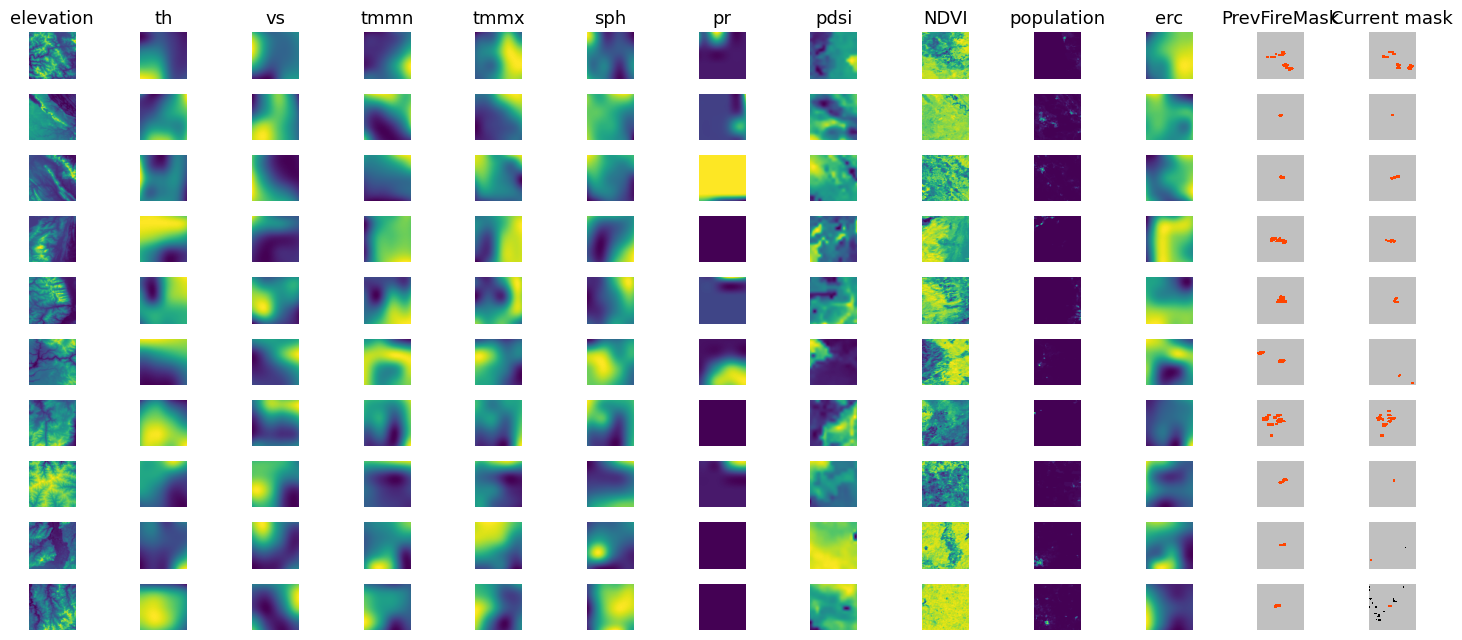

In [ ]:
TITLES = INPUT_FEATURES + ["Current mask"]  # Assuming you want to label your plots accordingly
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

fig, axes = plt.subplots(nrows=10, ncols=len(TITLES), figsize=(15, 6.5))
for i in range(10):
    for j in range(len(TITLES)):
        ax = axes[i, j]
        if i == 0:
            ax.set_title(TITLES[j], fontsize=13)
        if j < len(INPUT_FEATURES)-1:
            im = ax.imshow(inputs[i, :, :, j], cmap='viridis')
        elif j == len(INPUT_FEATURES):  # Last INPUT_FEATURE
            im = ax.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
        else:  # OUTPUT_FEATURE
            im = ax.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM)
        ax.axis('off')
plt.tight_layout()

## Data exploration
Data analysis of the initial dataset

Let's plot parameters distribution to explore dataset

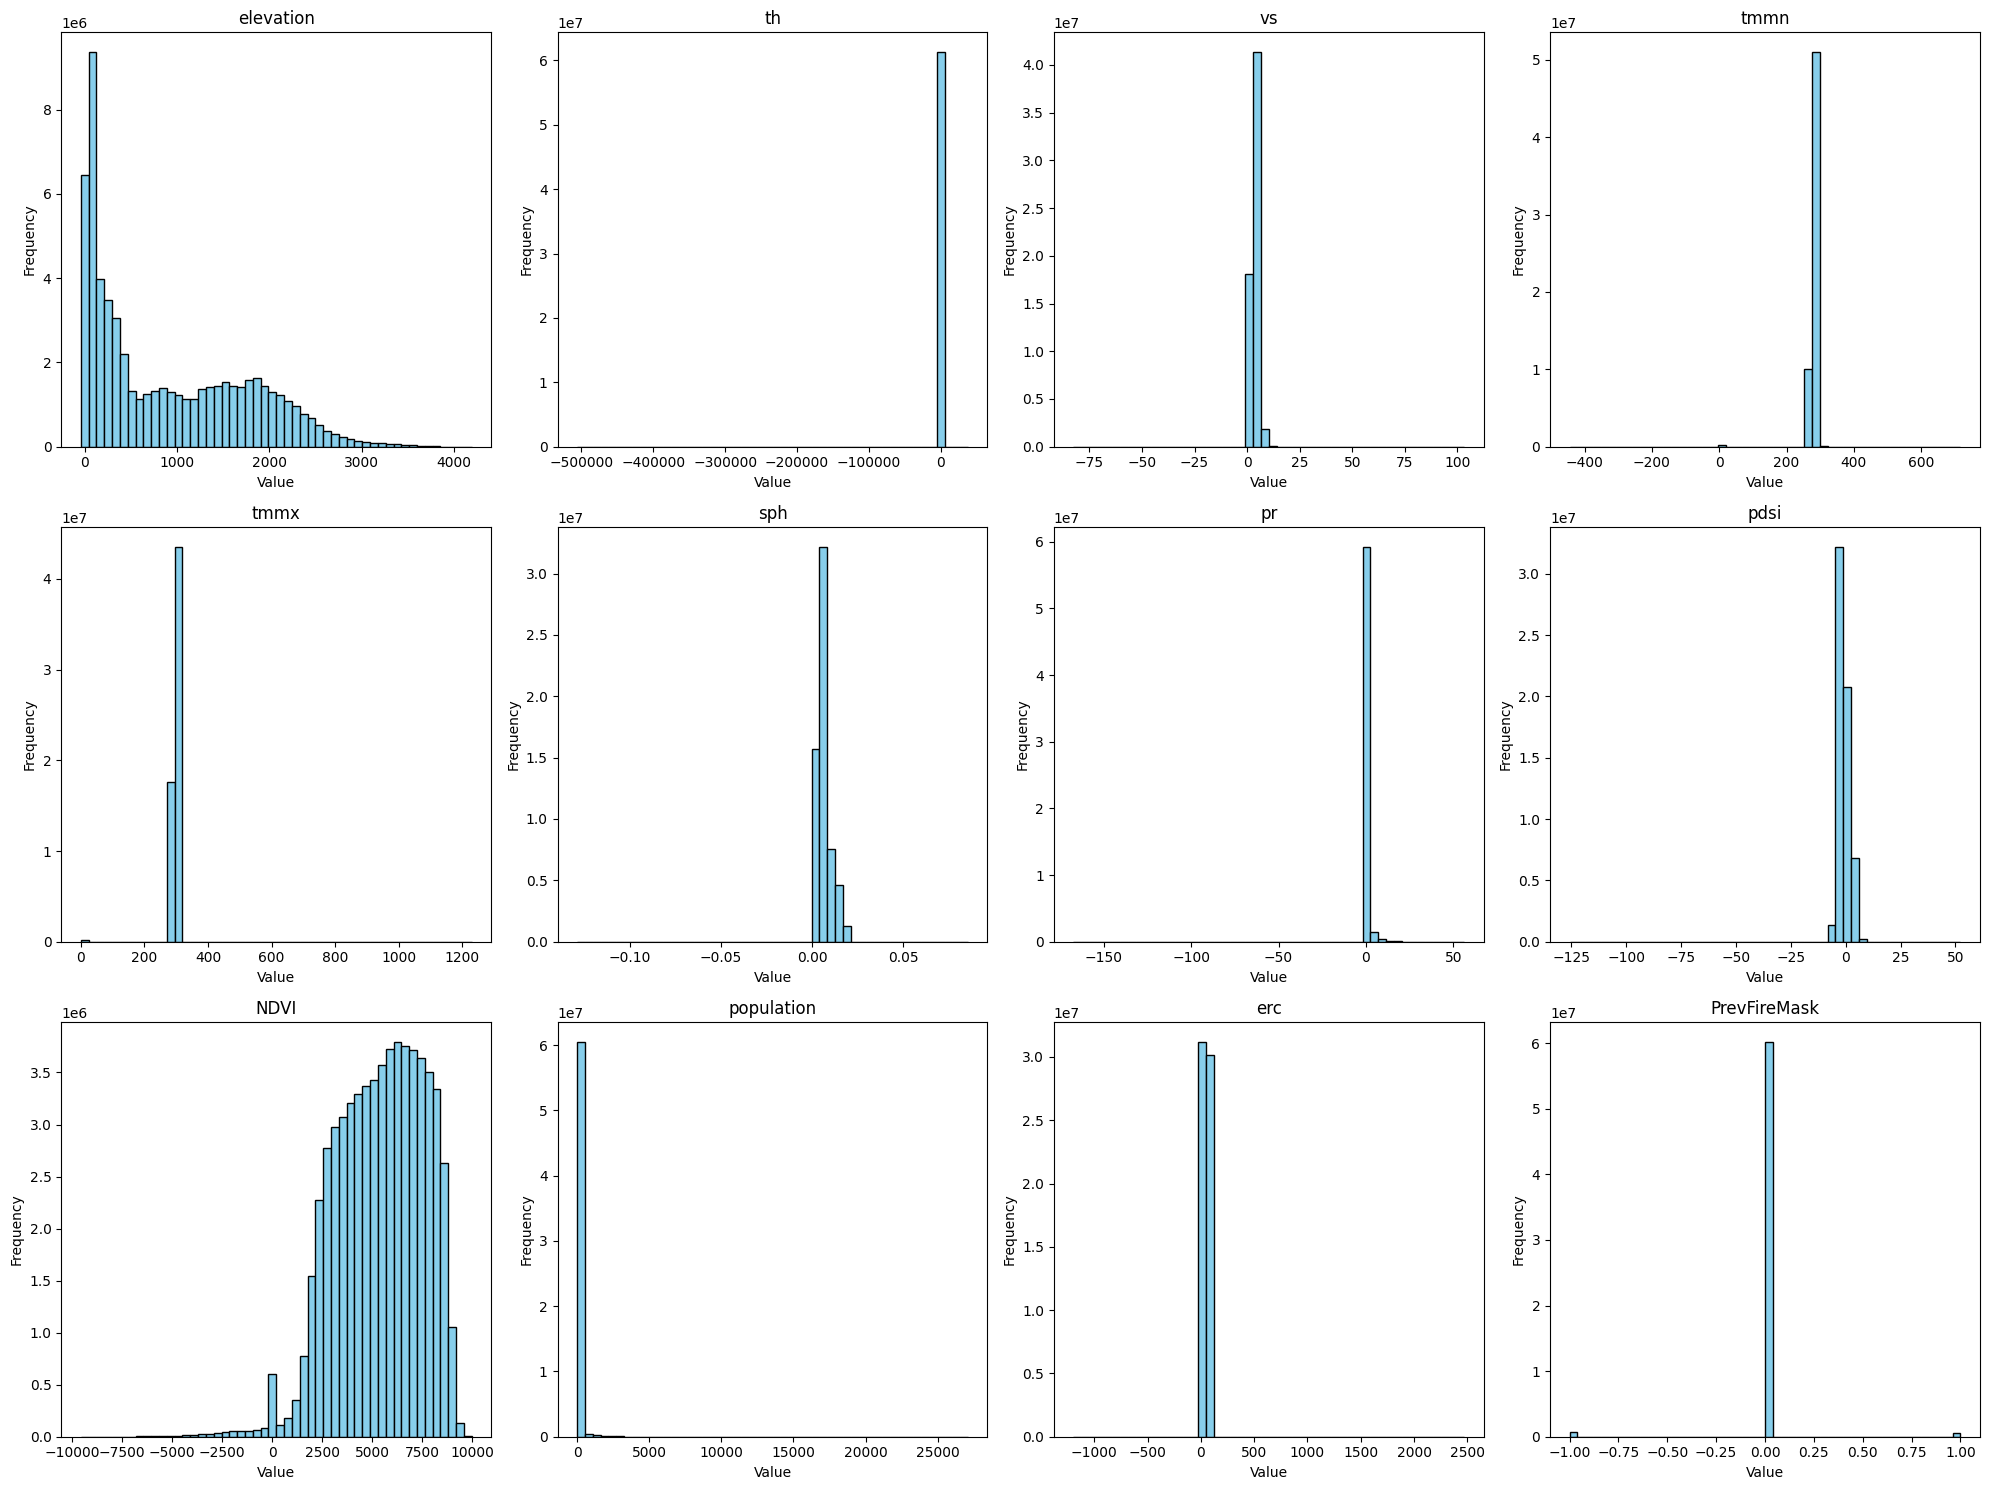

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf  # Ensure TensorFlow is imported

# Create a figure for the subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
axes = axes.ravel()  # Use ravel() for easy linear indexing

for i, feature_name in enumerate(INPUT_FEATURES):
    # Convert the specific feature data to a NumPy array and flatten it
    feature_data = inputs[:, :, :, i].numpy().flatten()

    # Use the min and max of the feature data for the histogram range
    data_min, data_max = feature_data.min(), feature_data.max()

    ax = axes[i]
    ax.hist(feature_data, bins=50, range=(data_min, data_max), color='skyblue', edgecolor='black')
    ax.set_title(feature_name)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Hide unused subplots if the number of INPUT_FEATURES is less than the subplot grid size
for i in range(len(INPUT_FEATURES), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Create dictionary with the statistics

In [ ]:
# Initialize the DATA_STATS dictionary with FireMask's predefined values
DATA_STATS = {'FireMask': (-1., 1., 0., 1.)}

# Iterate through the input features to calculate and store statistics
for i, feature_name in enumerate(INPUT_FEATURES):
    feature_data = inputs[:, :, :, i].numpy()  # Ensure inputs is a NumPy array

    # Calculate statistics
    percentile_1 = np.percentile(feature_data, 1)
    percentile_99 = np.percentile(feature_data, 99)
    mean = np.mean(feature_data)
    std = np.std(feature_data)

    # Store statistics in the dictionary, directly mapping feature name to its stats tuple
    DATA_STATS[feature_name] = (percentile_1, percentile_99, mean, std)

# Assuming the 'inputs' array and 'INPUT_FEATURES' list are already prepared
# This example directly assigns the computed statistics as a tuple to the feature key in DATA_STATS
keys_to_adjust = ['vs', 'pr', 'pdsi']

# Adjust the first value of the statistics tuple for the specified keys
for key in keys_to_adjust:
    if key in DATA_STATS:
        # Unpack the original stats
        _, percentile_99, mean, std = DATA_STATS[key]
        # Set the first value to 0 and update the dictionary
        DATA_STATS[key] = (0, percentile_99, mean, std)

# Print the updated DATA_STATS dictionary for verification
for feature, stats in DATA_STATS.items():
    print(f"{feature}: {stats}")

FireMask: (-1.0, 1.0, 0.0, 1.0)
elevation: (2.0, 2954.0, 896.56946, 842.6101)
th: (30.895117626190185, 330.64422607421875, 146.64645, 3435.077)
vs: (0, 7.537329196929932, 3.627856, 1.3092153)
tmmn: (264.7178903198242, 297.0799560546875, 281.85242, 18.497185)
tmmx: (277.6026306152344, 312.7354431152344, 297.71628, 19.458084)
sph: (0.0012003452284261584, 0.01778058148920536, 0.0065263137, 0.0037355348)
pr: (0, 7.522816829681403, 0.32342854, 1.5336567)
pdsi: (0, 5.246324620246888, -0.7728698, 2.440723)
NDVI: (0.0, 8936.0, 5350.6724, 2185.22)
population: (0.0, 850.5584716796875, 30.460333, 214.2003)
erc: (11.27055835723877, 104.08854675292969, 53.46907, 25.097979)
PrevFireMask: (-1.0, 0.0, -0.002722855, 0.13831195)


In [ ]:
INPUT_FEATURES

['elevation',
 'th',
 'vs',
 'tmmn',
 'tmmx',
 'sph',
 'pr',
 'pdsi',
 'NDVI',
 'population',
 'erc',
 'PrevFireMask']

In [ ]:
len(inputs)

14979

In [ ]:
inputs.shape

TensorShape([14979, 64, 64, 12])

In [ ]:
n_features = 12
X = inputs.numpy().reshape([len(inputs)*64*64,n_features])


In [ ]:
X.shape

(61353984, 12)

In [ ]:
corr = np.corrcoef(X.T)

In [ ]:
corr

array([[ 1.00000000e+00,  8.95204117e-03,  4.16158162e-02,
        -4.91206846e-02,  3.83518943e-03, -4.53742269e-01,
        -9.69577595e-02, -2.14973558e-01, -1.83327236e-01,
        -1.10397952e-01,  6.31103648e-01,  1.46194745e-02],
       [ 8.95204117e-03,  1.00000000e+00,  5.67104146e-03,
        -1.77020466e-03, -4.25939415e-04, -1.63066750e-02,
        -1.46111917e-02, -1.91747904e-03, -6.54134915e-03,
         9.17179610e-04,  1.01825472e-02,  2.90504675e-03],
       [ 4.16158162e-02,  5.67104146e-03,  1.00000000e+00,
         5.65282480e-02,  5.48344452e-02, -1.94125222e-01,
         3.86950813e-02, -8.02998691e-02, -1.31672077e-01,
        -6.56712562e-03,  1.37506083e-03, -2.26329815e-02],
       [-4.91206846e-02, -1.77020466e-03,  5.65282480e-02,
         1.00000000e+00,  9.84119775e-01,  3.76634443e-01,
         4.10925264e-02,  2.40477411e-03,  1.85137600e-01,
         2.30260928e-02,  1.75619827e-01,  5.97513381e-02],
       [ 3.83518943e-03, -4.25939415e-04,  5.4834445

In [ ]:
ax = [
  'Elevation',
  'Wind direction',
  'Wind velocity',
  'Min temp',
  'Max temp',
  'Humidity',
  'Precipation',
  'Drought',
  'Vegetation',
  'Population density',
  'Energy release component',
  'Previous fire mask'
]



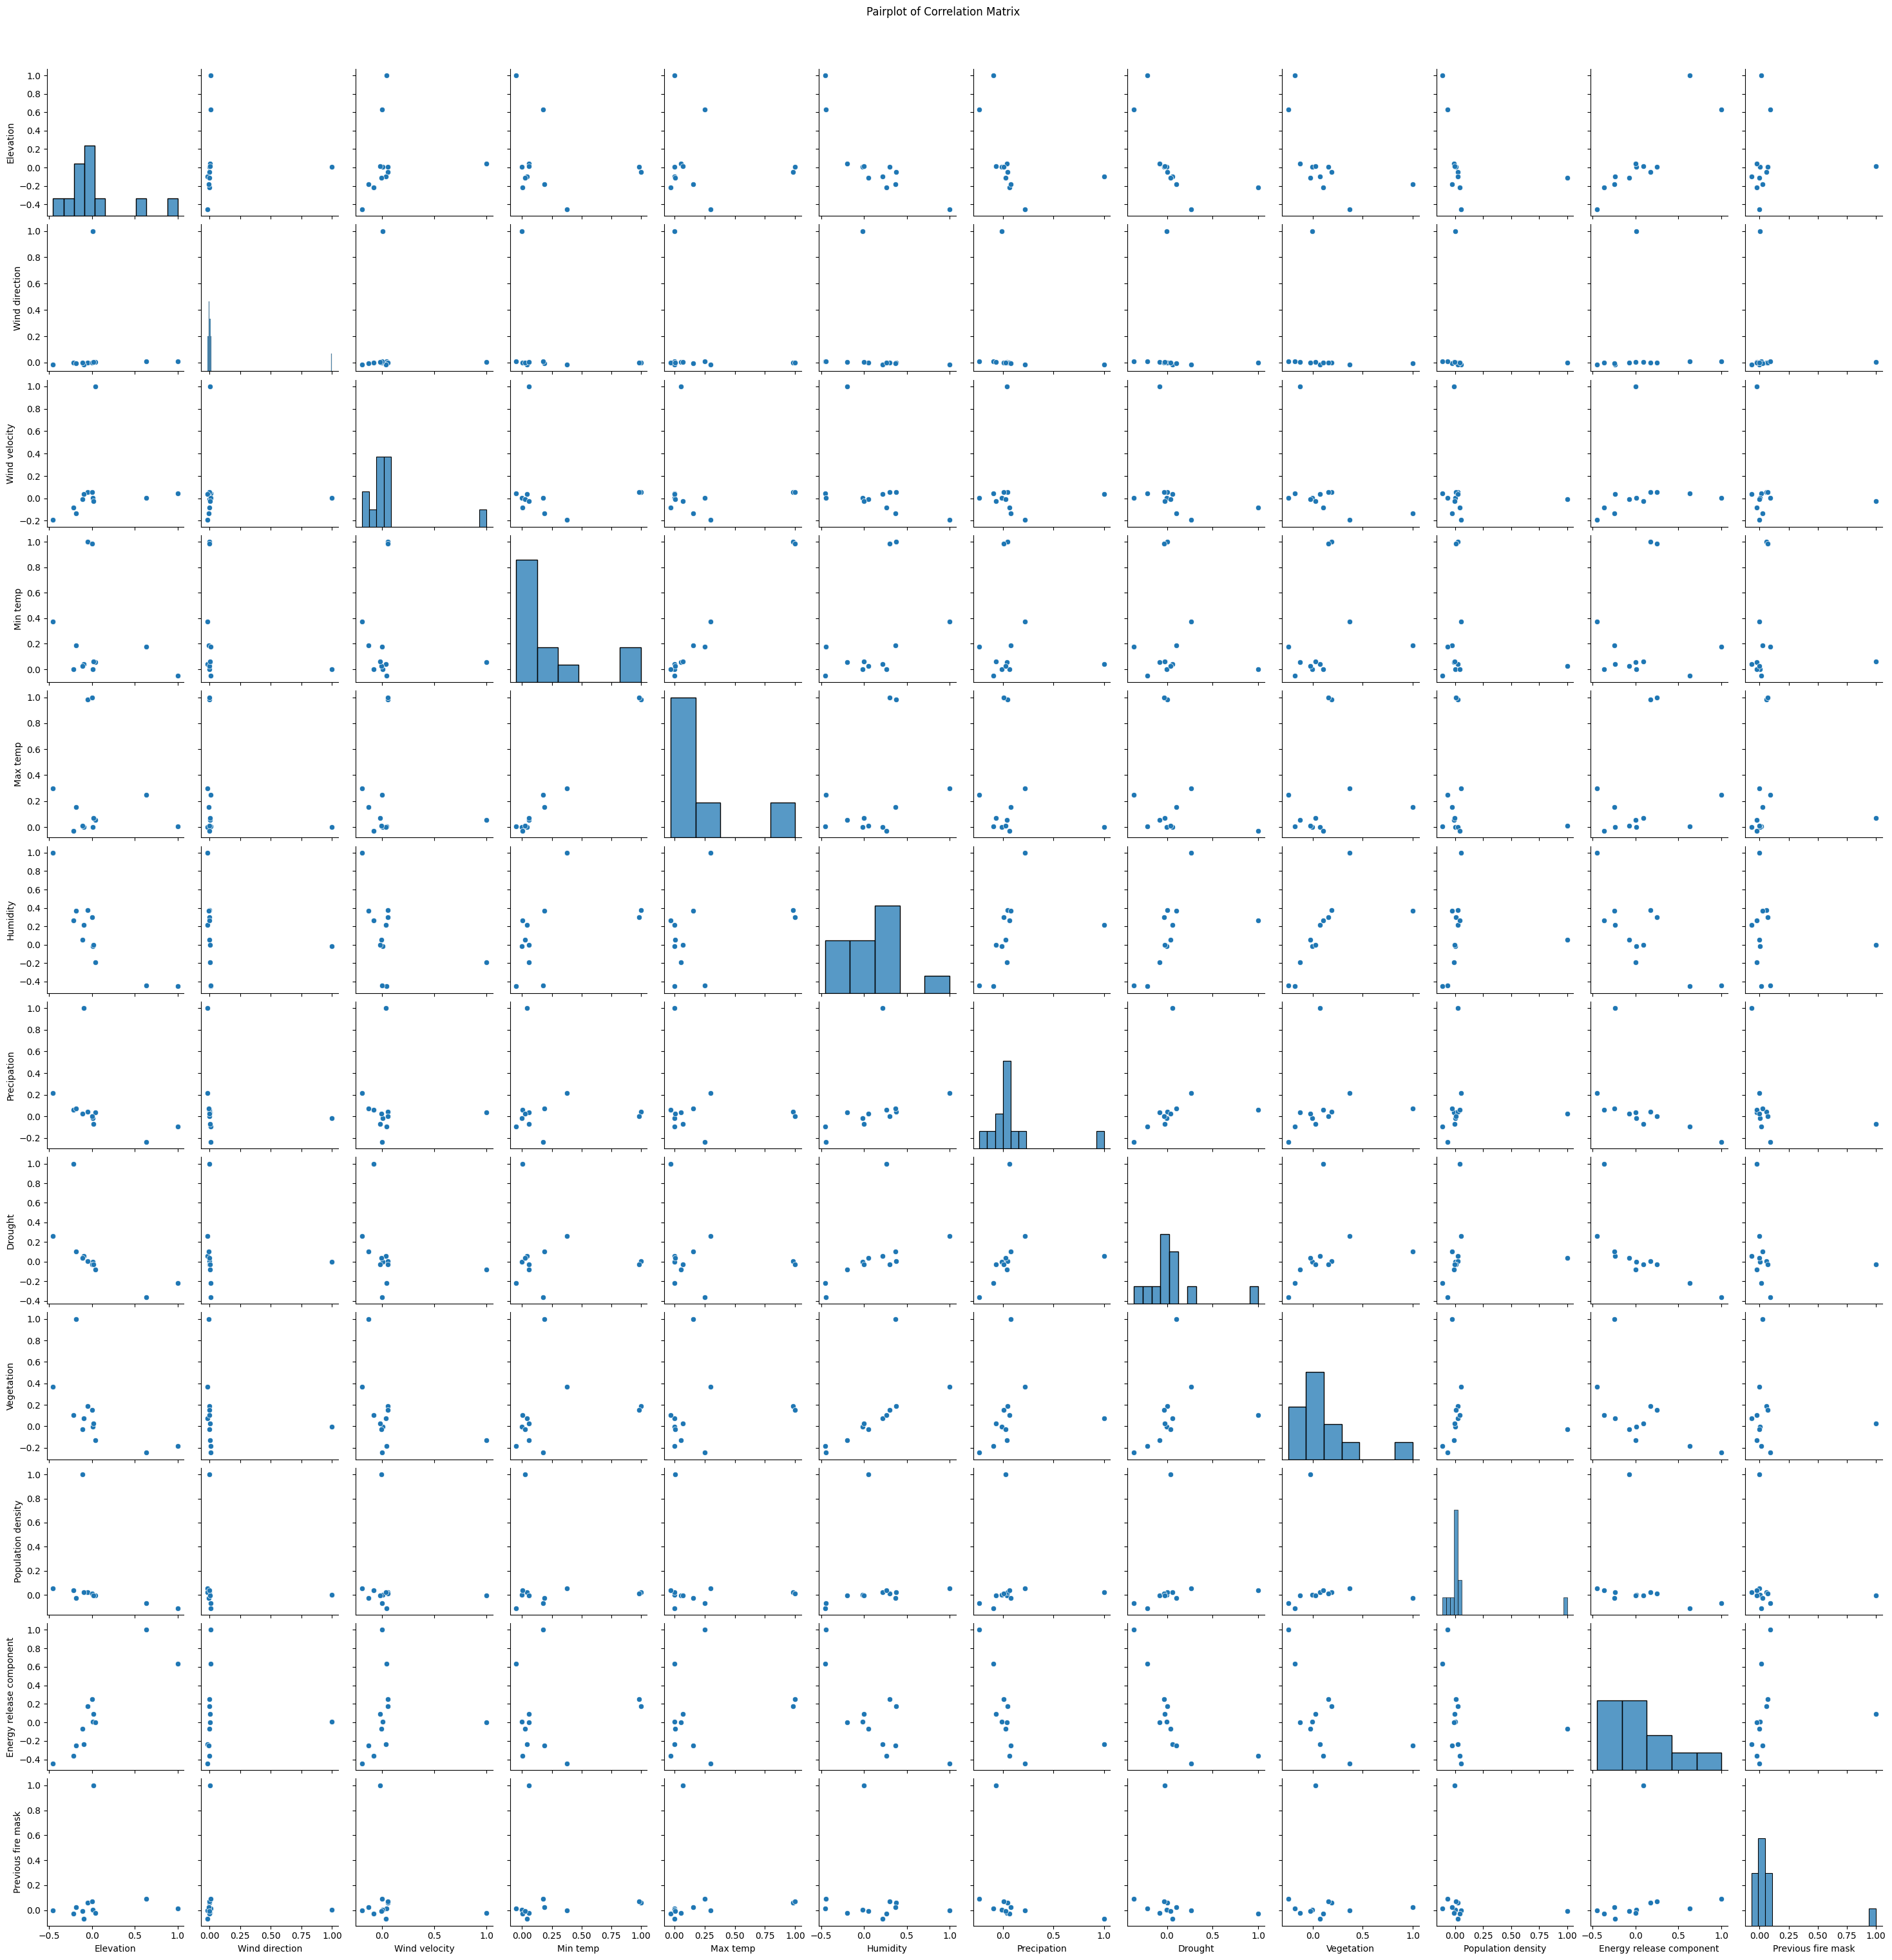

In [ ]:
corr_df = pd.DataFrame(corr, columns=ax, index=ax)

# Create a pairplot
sns.pairplot(corr_df)
plt.suptitle('Pairplot of Correlation Matrix', y=1.02)
plt.show()

<ipython-input-22-590b5306ec5a>:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(dist, method='complete')


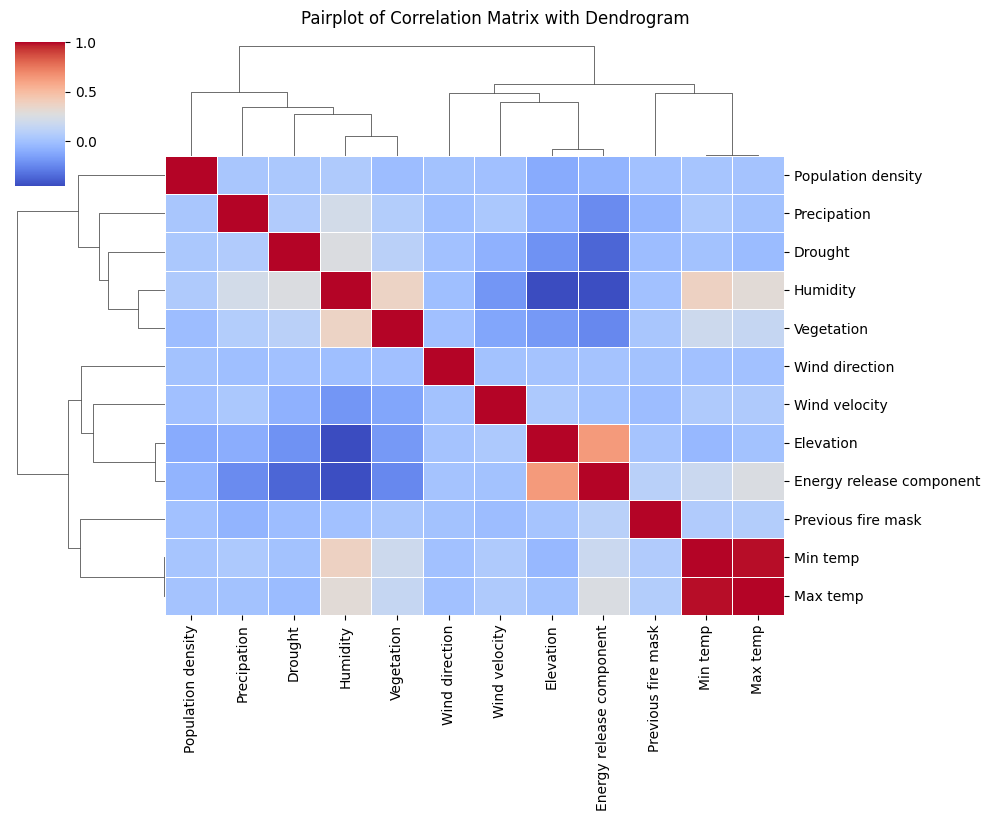

In [ ]:
dist = 1 - corr

# Apply hierarchical clustering
linkage = hierarchy.linkage(dist, method='complete')

# Create a pairplot
sns.clustermap(corr_df, method='complete', metric='correlation', figsize=(10, 8), cmap='coolwarm', linewidths=0.5,
               row_cluster=True, col_cluster=True)

plt.suptitle('Pairplot of Correlation Matrix with Dendrogram', y=1.02)
plt.show()

In [ ]:
y = labels.numpy().reshape([len(labels)*64*64])

In [ ]:
X[:,0].shape

(61353984,)

In [ ]:
for i in range(n_features):
  print(TITLES[i],"correlation")
  print(np.corrcoef(X[:,i],y)[0,1])

elevation correlation
0.028568062019846026
th correlation
0.00032198192694526565
vs correlation
-0.02191669830439894
tmmn correlation
0.06203839607044146
tmmx correlation
0.07218653979491178
sph correlation
0.017075443623511308
pr correlation
-0.10273612830281721
pdsi correlation
-0.0424219553570491
NDVI correlation
0.03244042399383996
population correlation
-0.000989065627310458
erc correlation
0.12102090954898877
PrevFireMask correlation
0.18589915512070748


## Build model


In [ ]:
from tensorflow.keras import layers, models
from keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU
from keras.layers import BatchNormalization, Activation, MaxPooling2D
from keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os

In [ ]:
val_file_pattern = '/content/drive/MyDrive/Colab Notebooks/CV_data/next_day_wildfire_spread/next_day_wildfire_spread_eval*'
test_file_pattern = '/content/drive/MyDrive/Colab Notebooks/CV_data/next_day_wildfire_spread/next_day_wildfire_spread_test*'

In [ ]:
def get_metrics(precs, recs):
  f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))
  return precs[np.argmax(f1s)], recs[np.argmax(f1s)]


In [ ]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
    num_in_channels: Number of channels in `input_img`.
    num_out_channels: Number of channels in `output_img`.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Calls `tf.image.central_crop` on input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img

In [ ]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.

  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '([a-zA-Z]+)'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.

  Args:
    key: Input key.

  Returns:
    The corresponding base key.

  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'([a-zA-Z]+)', key)
  if match:
    return match.group(1)
  raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))

# Modified

def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]

  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)

  weights = tf.cast(tf.greater_equal(output_img, tf.zeros_like(output_img)), tf.int32)

  return input_img, output_img, weights


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
def get_metrics(precs, recs):
  f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))
  return precs[np.argmax(f1s)], recs[np.argmax(f1s)]

In [ ]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

In [ ]:
file_pattern = '/content/drive/MyDrive/Colab Notebooks/CV_data/next_day_wildfire_spread/next_day_wildfire_spread_train*'
val_file_pattern = '/content/drive/MyDrive/Colab Notebooks/CV_data/next_day_wildfire_spread/next_day_wildfire_spread_eval*'
test_file_pattern = '/content/drive/MyDrive/Colab Notebooks/CV_data/next_day_wildfire_spread/next_day_wildfire_spread_test*'

In [ ]:
one_batch = get_dataset(
      file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=32, #We don't go through the whole dataset at once. It takes 468 loops to do the whole thing.
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

dataset = get_dataset(
      file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=14979,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

valset = get_dataset(
      val_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=1877,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=False,
      center_crop=True)

testset = get_dataset(
      test_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=1877,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=False,
      center_crop=True)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU
from keras.layers import BatchNormalization, Activation, MaxPooling2D
from keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os

In [ ]:
def conv_block(prev_output, filters, kernel):
    x = Conv2D(filters, kernel, padding = "same")(prev_output)
    x = layers.BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = Conv2D(filters, kernel, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    return LeakyReLU(0.1)(x)

def up_conv_block(prev_output, filters, kernel):
    x = Conv2D(filters, kernel, padding = "same")(prev_output)
    x = layers.BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = Conv2D(filters//2, kernel, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    return LeakyReLU(0.1)(x)

In [ ]:
# ALTERNO

from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU

def conv_block(prev_output, filters, kernel_size, apply_leaky_relu=True):
    """Applies two convolution operations each followed by batch normalization and LeakyReLU activation.

    Args:
        prev_output: Input tensor from the previous layer.
        filters: Integer, the dimensionality of the output space (i.e., the number of output filters in the convolution).
        kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window.
        apply_leaky_relu: Boolean, applies LeakyReLU activation if True, otherwise no activation is applied after the second convolution.

    Returns:
        Output tensor for the block.
    """
    x = Conv2D(filters, kernel_size, padding="same")(prev_output)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)

    # For the second conv, optionally apply LeakyReLU based on apply_leaky_relu flag.
    x = Conv2D(filters, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    if apply_leaky_relu:
        x = LeakyReLU(0.1)(x)
    return x

def up_conv_block(prev_output, filters, kernel_size):
    """Applies an up-sampling convolution operation followed by batch normalization and LeakyReLU activation,
    and then a convolution operation to reduce the number of filters by half, followed by batch normalization and LeakyReLU.

    Args:
        prev_output: Input tensor from the previous layer.
        filters: Integer, the dimensionality of the output space (i.e., the number of output filters in the convolution).
        kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window.

    Returns:
        Output tensor for the block.
    """
    # Increase dimensions with first convolution
    x = Conv2D(filters, kernel_size, padding="same")(prev_output)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)

    # Reduce dimensions back down with second convolution, halving the filters
    x = Conv2D(filters // 2, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    return LeakyReLU(0.1)(x)


In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import MaxPooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def create_unet_model(input_shape, num_filters=32, num_classes=1):
    """
    Creates a UNet model.

    Args:
        input_shape (tuple): Shape of the input image.
        num_filters (int): Number of base filters in the convolutional layers.
        num_classes (int): Number of output classes.

    Returns:
        model (tf.keras.Model): Compiled UNet model.
    """
    inputs = Input(shape=input_shape, name="original_img")

    # Downsampling through the model
    filters = num_filters
    skips = []
    x = inputs
    for _ in range(3):
        x = conv_block(x, filters, 3)
        skips.append(x)
        x = MaxPooling2D(2)(x)
        filters *= 2  # Double the number of filters with each layer

    # Bottleneck
    x = conv_block(x, filters, 3)

    # Upsampling and establishing the skip connections
    for filters in reversed(skips):
        x = Conv2DTranspose(filters.shape[-1], 3, strides=2, padding="same")(x)
        x = layers.BatchNormalization()(x)
        skip_output = filters
        x = layers.add([skip_output, x])
        x = up_conv_block(x, filters.shape[-1] * 2, 3)

    # Final layer of the model
    outputs = Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Model configuration
input_shape = (32, 32, 12)  # Example input shape, adjust based on your dataset
model = create_unet_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

# # Model training callbacks
# callbacks = [
#     ModelCheckpoint('best_model.hdf5', monitor='val_loss', save_best_only=True),
#     EarlyStopping(monitor='val_loss', patience=5, verbose=1)
# ]



# # stop training if it's overfitting # may need to increase regularization
# early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
# CALLBACKS=[checkpoint,early]


# Model summary
model.summary()

# Note: The training part with `model.fit` should be called with appropriate datasets


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 original_img (InputLayer)   [(None, 32, 32, 12)]         0         []                            
                                                                                                  
 conv2d_30 (Conv2D)          (None, 32, 32, 32)           3488      ['original_img[0][0]']        
                                                                                                  
 batch_normalization_34 (Ba  (None, 32, 32, 32)           128       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 leaky_re_lu_28 (LeakyReLU)  (None, 32, 32, 32)           0         ['batch_normalization_34

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import MaxPooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def create_unet_model(input_shape, num_filters=32, num_classes=1):
    """
    Creates a UNet model.

    Args:
        input_shape (tuple): Shape of the input image.
        num_filters (int): Number of base filters in the convolutional layers.
        num_classes (int): Number of output classes.

    Returns:
        model (tf.keras.Model): Compiled UNet model.
    """
    inputs = Input(shape=input_shape, name="original_img")

    # Downsampling through the model
    filters = num_filters
    skips = []
    x = inputs
    for _ in range(3):
        x = conv_block(x, filters, 3)
        skips.append(x)
        x = MaxPooling2D(2)(x)
        filters *= 2  # Double the number of filters with each layer

    # Bottleneck
    x = conv_block(x, filters, 3)

    # Upsampling and establishing the skip connections
    for filters in reversed(skips):
        x = Conv2DTranspose(filters.shape[-1], 3, strides=2, padding="same")(x)
        x = layers.BatchNormalization()(x)
        skip_output = filters
        x = layers.add([skip_output, x])
        x = up_conv_block(x, filters.shape[-1] * 2, 3)

    # Final layer of the model
    outputs = Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Model configuration
input_shape = (32, 32, 12)  # Example input shape, adjust based on your dataset
model = create_unet_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

# Model training callbacks
callbacks = [
    ModelCheckpoint('best_model.hdf5', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1)
]



# stop training if it's overfitting # may need to increase regularization
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
CALLBACKS=[checkpoint,early]


# Model summary
model.summary()

# Note: The training part with `model.fit` should be called with appropriate datasets



# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics = [tf.keras.metrics.AUC()])
# optimizer changed to adam from rmsprop because it's spoopier

# Save the best model.
checkpoint = ModelCheckpoint('best_default_model.hdf5', monitor='val_loss', save_best_only=True, save_freq=1)

# stop training if it's overfitting # may need to increase regularization
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
CALLBACKS=[checkpoint,early]

NameError: name 'checkpoint' is not defined

In [ ]:
EPOCHS = 10

history = model.fit(one_batch, #tf.data.dataset takes full advantage of the data generator above
          epochs = EPOCHS,
          validation_data = valset,
          #callbacks = CALLBACKS
                    )

Epoch 1/10
    469/Unknown - 17s 19ms/step - loss: 0.2053 - auc_2: 0.5221

469/469 [==============================] - 40s 67ms/step - loss: 0.2053 - auc_2: 0.5221 - val_loss: 0.1587 - val_auc_2: 0.5197
Epoch 2/10
469/469 [==============================] - ETA: 0s - loss: 0.1118 - auc_2: 0.5759

469/469 [==============================] - 9s 18ms/step - loss: 0.1118 - auc_2: 0.5759 - val_loss: 0.1554 - val_auc_2: 0.5408
Epoch 3/10
469/469 [==============================] - ETA: 0s - loss: 0.1066 - auc_2: 0.5743

469/469 [==============================] - 9s 18ms/step - loss: 0.1066 - auc_2: 0.5743 - val_loss: 0.1492 - val_auc_2: 0.5978
Epoch 4/10
465/469 [============================>.] - ETA: 0s - loss: 0.1043 - auc_2: 0.5882

469/469 [==============================] - 9s 18ms/step - loss: 0.1044 - auc_2: 0.5887 - val_loss: 0.1505 - val_auc_2: 0.5772
Epoch 5/10
466/469 [============================>.] - ETA: 0s - loss: 0.1027 - auc_2: 0.5960

469/469 [==============================] - 9s 18ms/step - loss: 0.1027 - auc_2: 0.5961 - val_loss: 0.1472 - val_auc_2: 0.6157
Epoch 6/10
467/469 [============================>.] - ETA: 0s - loss: 0.1018 - auc_2: 0.6047

469/469 [==============================] - 9s 18ms/step - loss: 0.1018 - auc_2: 0.6048 - val_loss: 0.1550 - val_auc_2: 0.6142
Epoch 7/10
468/469 [============================>.] - ETA: 0s - loss: 0.1008 - auc_2: 0.6052

469/469 [==============================] - 9s 18ms/step - loss: 0.1008 - auc_2: 0.6052 - val_loss: 0.1572 - val_auc_2: 0.5802
Epoch 8/10
466/469 [============================>.] - ETA: 0s - loss: 0.0994 - auc_2: 0.6100

469/469 [==============================] - 9s 19ms/step - loss: 0.0995 - auc_2: 0.6101 - val_loss: 0.1543 - val_auc_2: 0.6123
Epoch 9/10
469/469 [==============================] - ETA: 0s - loss: 0.0991 - auc_2: 0.6153

469/469 [==============================] - 9s 18ms/step - loss: 0.0991 - auc_2: 0.6153 - val_loss: 0.1596 - val_auc_2: 0.5959
Epoch 10/10
468/469 [============================>.] - ETA: 0s - loss: 0.0973 - auc_2: 0.6118

469/469 [==============================] - 9s 18ms/step - loss: 0.0973 - auc_2: 0.6119 - val_loss: 0.1507 - val_auc_2: 0.6195


In [ ]:
# Evaluate the model on the test set
test_loss, test_auc = model.evaluate(testset, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test AUC: {test_auc}")


1/1 - 24s - loss: 0.1384 - auc_2: 0.5992 - 24s/epoch - 24s/step
Test Loss: 0.13842760026454926
Test AUC: 0.599179744720459


In [ ]:
# Assuming the structure is (input_img, output_img, weights)
true_labels = np.concatenate([y.numpy().flatten() for x, y, w in testset], axis=0)


In [ ]:
# Assuming a binary classification problem with a threshold of 0.5 for predictions
threshold = 0.5
predictions = model.predict(testset)
predictions_binary = (predictions > threshold).astype(int)  # This will be a NumPy array

# Compute metrics using TensorFlow
# No need to manually flatten or concatenate; TensorFlow can handle batched predictions and labels directly
true_labels = tf.concat([y for x, y, w in testset], axis=0)

# Convert predictions to TensorFlow tensor to compute metrics
predictions_tensor = tf.convert_to_tensor(predictions_binary, dtype=true_labels.dtype)

# Calculate metrics using TensorFlow
# This is just an example; for custom metrics or more detailed analysis, consider using sklearn or manual calculations
accuracy = tf.metrics.BinaryAccuracy()
accuracy.update_state(true_labels, predictions_tensor)
print(f"Accuracy: {accuracy.result().numpy()}")


1/1 [==============================] - 1s 845ms/step
Accuracy: 0.9383690357208252


In [ ]:
precision = tf.metrics.Precision()
recall = tf.metrics.Recall()

# Update states with the true labels and predictions
precision.update_state(true_labels, predictions_tensor)
recall.update_state(true_labels, predictions_tensor)

precision_value = precision.result().numpy()
recall_value = recall.result().numpy()
f1_score = 2 * (precision_value * recall_value) / (precision_value + recall_value)

print(f"Precision: {precision_value}")
print(f"Recall: {recall_value}")
print(f"F1-Score: {f1_score}")


Precision: 0.761904776096344
Recall: 0.00015008817717898637
F1-Score: 0.0003001172399075659


In [ ]:
auc = tf.metrics.AUC()

# Update state with the true labels and predictions
auc.update_state(true_labels, predictions)

auc_value = auc.result().numpy()
print(f"AUC: {auc_value}")


AUC: 0.599179744720459


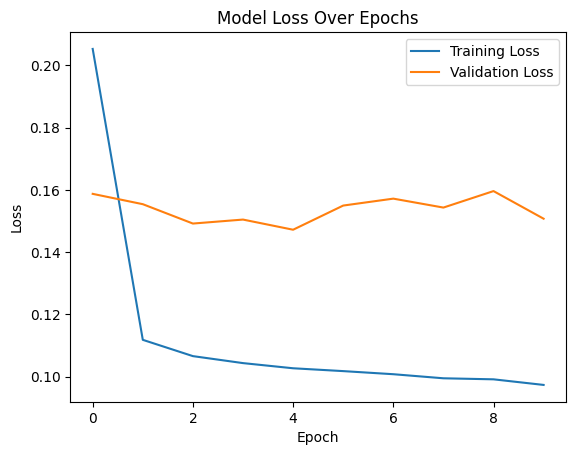

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
